In [37]:
from daqx.util import createDevice
import time
import numpy as np
from matplotlib import pyplot as plt

### General DAQ setup

In [38]:
daq = createDevice('mcc',0)
daq.config_ai(0,1)
daq.config_ao(0,1)

In [39]:
def foo(eventdata,*arg,**kwarg):
    #print('callback executed')
    if eventdata['event'] == 'samplesAcquiredFcn':
        print(f'{time.ctime(eventdata["time"])}: {eventdata["event"]} called at {eventdata["samplesAcquired"]}')
    else:
        print(f'{time.ctime(eventdata["time"])}: {eventdata["event"]} called with arg = {"".join(arg)}')

def collectdata(eventdata,ai,N,obj):
    print(f'{time.ctime(eventdata["time"])}: {eventdata["event"]} called at {eventdata["samplesAcquired"]}')
    timept, data = ai.getdata(N)
    obj.time = np.hstack((obj.time,timept))
    obj.data = np.hstack((obj.data,data))

class daqdata:
    def __init__(self,t,d):
        self.time = t
        self.data = d
   
aidata = daqdata([],[[],[]])

AI has already stopped
AO has already stopped


### Set up AI

In [40]:
daq.ai.sampleRate = 1000 # Hz/channel
daq.ai.grounding = 'single-ended' #e.g. single_ended
daq.ai.iscontinuous = True # if True -> Inf
#daq.ai.trigType = 'instant'
daq.ai.trigType = 'digital-positive-edge'
daq.ai.trigRepeat = 1
daq.ai.trigFcn = (foo,'AItrig')
daq.ai.samplesPerTrig = 900 # in samples/channel
daq.ai.samplesAcquiredFcnCount = 1800 # in samples/channel; 0 means no function to be called
#daq.ai.samplesAcquiredFcn = (foo,) # ',' makes it a tuple
daq.ai.samplesAcquiredFcn = (collectdata,(daq.ai,daq.ai.samplesAcquiredFcnCount,aidata))
# daq.ai.samplesAcquiredFcn = None
daq.ai.startFcn = (foo,'AIstart')
daq.ai.stopFcn = (foo,'AIstop')
#daq.ai.aqMode = 'foreground' # acquisition mode
daq.ai.aqMode = 'background' # acquisition mode  

### Set up AO

In [41]:
# Parameters
F1 = 10  # Hz
A1 = 5.0  # +/- amplitude
offset1 = 0  # No offset
aoSR = 5*1000  # Hz
duration = 1 # sec
num_samples = int(aoSR * duration) # 1 sec of data

# Generate a sine wave buffer
t = np.linspace(0, duration, num_samples, endpoint=False)  # Time vector for cycle * one period
aodata = np.zeros((2,int(aoSR * duration))) #2 channels
aodata[0,0:5] = 2 #trigger points
aodata[1,:] = A1 * np.sin(2 * np.pi * F1 * t) + offset1 #sine wave

# Plotting
# fig = plt.figure()
# plt.plot(t,aodata[0,:])
# plt.plot(t,aodata[1,:],color = 'r')
# plt.grid(True)
# fig.canvas.toolbar_position = 'top'

# Prep AO
daq.ao.sampleRate = aoSR
daq.ao.endMode = 'zero'
daq.ao.startFcn = (foo,'AOstart')
daq.ao.stopFcn = (foo,'AOstop')

daq.ao.putdata(aodata)

### Start AI,AO

In [42]:
aidata.time = []
aidata.data = [[],[]]
daq.ai.start()
daq.ao.start()

Thu Jan  9 23:00:39 2025: AItrigFcn called with arg = AItrig
Thu Jan  9 23:00:39 2025: AIstartFcn called with arg = AIstart
Thu Jan  9 23:00:39 2025: AOstartFcn called with arg = AOstart


Thu Jan  9 23:00:40 2025: AItrigFcn called with arg = AItrig
Thu Jan  9 23:00:41 2025: AItrigFcn called with arg = AItrig
Thu Jan  9 23:00:41 2025: samplesAcquiredFcn called at 1920
Thu Jan  9 23:00:42 2025: AItrigFcn called with arg = AItrig
Thu Jan  9 23:00:43 2025: AItrigFcn called with arg = AItrig
Thu Jan  9 23:00:43 2025: samplesAcquiredFcn called at 3712
Thu Jan  9 23:00:44 2025: AItrigFcn called with arg = AItrig
Thu Jan  9 23:00:45 2025: AItrigFcn called with arg = AItrig
Thu Jan  9 23:00:45 2025: samplesAcquiredFcn called at 5504
Thu Jan  9 23:00:46 2025: AItrigFcn called with arg = AItrig
Thu Jan  9 23:00:47 2025: AItrigFcn called with arg = AItrig
Thu Jan  9 23:00:47 2025: samplesAcquiredFcn called at 7296
Thu Jan  9 23:00:48 2025: AItrigFcn called with arg = AItrig
Thu Jan  9 23:00:49 2025: AItrigFcn called with arg = AItrig
Thu Jan  9 23:00:49 2025: samplesAcquiredFcn called at 9088


In [43]:
daq.ai.stop()
daq.ao.stop()

Acquisition is done
win buffer freed
Thu Jan  9 23:00:49 2025: AIstopFcn called with arg = AIstop
Thu Jan  9 23:00:50 2025: AOstopFcn called with arg = AOstop


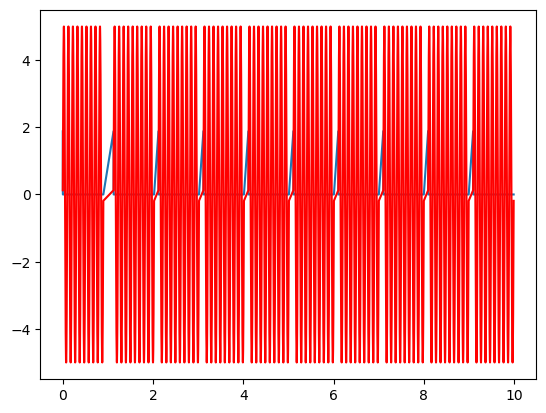

In [44]:
# print(len(daq.ai.data[0]))
# print(len(daq.ai.data[1]))
# plt.figure()
# plt.plot(daq.ai.data[0])
# plt.plot(daq.ai.data[1],'r')
#aitime, aidata = daq.ai.getdata()
plt.figure()
plt.plot(aidata.time,aidata.data[0])
plt.plot(aidata.time,aidata.data[1],'r')

In [ ]:
# t0 = daq.ai._trigTime[0]
# trigtime = [t-t0 for t in daq.ai._trigTime]
# print(trigtime)


In [ ]:
plt.close('all')